In [ ]:
# coding: utf-8
import re
import csv
import pandas as pd
import numpy as np
import time
from tqdm import trange
from matplotlib import pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from Functions import read_root,read_dir,generate_list,generate_valid_set,get_attack_dict,generate_dataset

# Data preprocess

In [2]:
root_dir = 'ADFA'
valid_dir_abs, validation_dir = read_dir(root_dir, 'Validation_Data_Master')
validation_dir = sorted(validation_dir)
valid_sequence_list = generate_list(valid_dir_abs, validation_dir, 'UVD')

train_dir_abs, training_dir = read_dir(root_dir, 'Training_Data_Master')
train_sequence_list = generate_list(train_dir_abs, training_dir, 'UTD')

slide = 20
M = 12
R = 8
n_feature = 1


training_set= generate_dataset(train_sequence_list, slide, n_feature)
valid_set = generate_dataset(valid_sequence_list, slide, n_feature)

evalate val progress:58.67%

# Training

In [ ]:
def autoEncoder(shape):
    model = Sequential()
    model.add(LSTM(16, input_length=20, input_dim=1, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))  
    model.add(LSTM(16, return_sequences=True))
    model.add(LSTM(shape[1]))
   
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [ ]:
print(training_set.shape)
print(valid_set.shape)
autoEncoder_model = autoEncoder(training_set.shape)

In [ ]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")

#autoEncoder_model = load_model('model/final_1_epoch.h5')

epochs = 50

for epoch in range(epochs):
    print(str(epoch) + ' epchs')
    #autoEncoder_model.fit(np.reshape(training_set, (-1, 1, slide)), np.reshape(training_set, (-1, slide)), epochs=1, batch_size=100, validation_data=(valid_set[:100], np.reshape(valid_set[:100], (-1, slide))), callbacks=[callback])

    autoEncoder_model.fit(training_set, np.reshape(training_set, (-1, slide)), epochs=1, batch_size=100, validation_data=(valid_set[:100], np.reshape(valid_set[:100], (-1, slide))), callbacks=[callback])
    autoEncoder_model.save('model/'+str(epoch) + '_epoch.h5')

# Testing

In [21]:
#autoEncoder_model.save('model/1201.h5')
model = load_model('model/1201.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 16)            1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 64)            20736     
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 16)            5184      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                2960      
Total params: 30,032
Trainable params: 30,032
Non-trainable params: 0
_________________________________________________________________


In [4]:
#predict_train = np.array(model.predict(training_set, batch_size=10000))
#predict_val = np.array(model.predict(valid_set, batch_size=10000))
#predict_train = np.reshape(predict_train, (-1, slide, 1))
#predict_val = np.reshape(predict_val, (-1, slide, 1))

#### Train loss 

In [5]:
train_loss = []
for i in range(1000):
    loss = model.evaluate(training_set[i:i+1], np.reshape(training_set[i:i+1], (-1, slide)))
    train_loss.append(loss)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


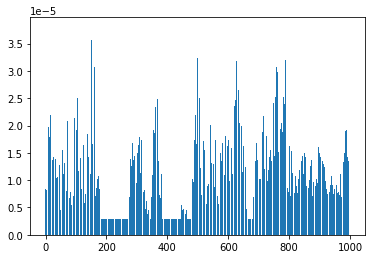

In [6]:
plt.bar(np.arange(len(train_loss)),train_loss)
plt.show()

#### Val loss

In [7]:
val_loss = []
for i in range(1000):
    loss = model.evaluate(valid_set[i:i+1], np.reshape(valid_set[i:i+1], (-1, slide)))
    val_loss.append(loss)

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


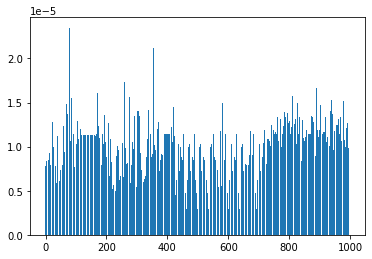

In [8]:
plt.bar(np.arange(len(val_loss)),val_loss)
plt.show()

#### Attack loss

In [9]:
attack_dict = get_attack_dict()

print('attack_type : ' + str(len(attack_dict)))
print('attack number each type : ' + str(len(attack_dict['Adduser'])))
print(len(attack_dict['Adduser'][0]))
print(len(attack_dict['Adduser'][0][0]))
#print(len(attack_dict['Adduser'][0][0][0]))
#print(len(attack_dict['Adduser'][0][0][0][0]))
print('Input size : ' + str(len(attack_dict['Adduser'][0][0][0])) + ', ' + str(len(attack_dict['Adduser'][0][0][0][0])))

ADFA\Attack_Data_Master
正在產生attack dataset...

attack_type : 6
attack number each type : 10
7
258
Input size : 20, 1


In [15]:
all_loss_list = []
for attack_type in attack_dict:
    print(attack_type + ' : ' + str(len(attack_dict[attack_type])))
    loss_list = []
    if attack_type == 'Adduser':
        for attack_index in range(len(attack_dict[attack_type])):
            print('attack_index : ' + str(attack_index) + ' txt number : ' + str(len(attack_dict[attack_type][attack_index])))
            if attack_index == 0:
                for txt_index in range(len(attack_dict[attack_type][attack_index])):
                   
                    print('txt_index : ' + str(txt_index) + ' number : ' + str(len(attack_dict[attack_type][attack_index][txt_index])))
                    for i in range(len(attack_dict[attack_type][attack_index][txt_index])):
                        print('txt_index : ' + str(txt_index) + ' number : ' + str(len(attack_dict[attack_type][attack_index][txt_index])) + ' index : ' + str(i))

                        loss = model.evaluate(attack_dict[attack_type][attack_index][txt_index][i:i+1], np.reshape(attack_dict[attack_type][attack_index][txt_index][i:i+1], (-1, slide)))
                        loss_list.append(loss)
        all_loss_list.append(loss_list)

Adduser : 10
attack_index : 0 number : 7
txt_index : 0 number : 258
txt_index : 0 number : 258 index : 0
1/1 [==============================] - 0s 32ms/step
txt_index : 0 number : 258 index : 1
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 2
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 3
1/1 [==============================] - 0s 32ms/step
txt_index : 0 number : 258 index : 4
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 5
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 6
1/1 [==============================] - 0s 30ms/step
txt_index : 0 number : 258 index : 7
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 8
1/1 [==============================] - 0s 24ms/step
txt_index : 0 number : 258 index : 9
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 10
1/1 

txt_index : 0 number : 258 index : 91
1/1 [==============================] - 0s 25ms/step
txt_index : 0 number : 258 index : 92
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 93
1/1 [==============================] - 0s 25ms/step
txt_index : 0 number : 258 index : 94
1/1 [==============================] - 0s 25ms/step
txt_index : 0 number : 258 index : 95
1/1 [==============================] - 0s 28ms/step
txt_index : 0 number : 258 index : 96
1/1 [==============================] - 0s 27ms/step
txt_index : 0 number : 258 index : 97
1/1 [==============================] - 0s 26ms/step
txt_index : 0 number : 258 index : 98
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 99
1/1 [==============================] - 0s 28ms/step
txt_index : 0 number : 258 index : 100
1/1 [==============================] - 0s 25ms/step
txt_index : 0 number : 258 index : 101
1/1 [==============================] - 0s 28ms/step
txt_inde

txt_index : 0 number : 258 index : 182
1/1 [==============================] - 0s 28ms/step
txt_index : 0 number : 258 index : 183
1/1 [==============================] - 0s 26ms/step
txt_index : 0 number : 258 index : 184
1/1 [==============================] - 0s 26ms/step
txt_index : 0 number : 258 index : 185
1/1 [==============================] - 0s 25ms/step
txt_index : 0 number : 258 index : 186
1/1 [==============================] - 0s 28ms/step
txt_index : 0 number : 258 index : 187
1/1 [==============================] - 0s 29ms/step
txt_index : 0 number : 258 index : 188
1/1 [==============================] - 0s 27ms/step
txt_index : 0 number : 258 index : 189
1/1 [==============================] - 0s 28ms/step
txt_index : 0 number : 258 index : 190
1/1 [==============================] - 0s 27ms/step
txt_index : 0 number : 258 index : 191
1/1 [==============================] - 0s 28ms/step
txt_index : 0 number : 258 index : 192
1/1 [==============================] - 0s 26ms/step

txt_index : 1 number : 745 index : 14
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 15
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 16
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 17
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 18
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 19
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 20
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 21
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 22
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 23
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 24
1/1 [==============================] - 0s 30ms/step
txt_index 

txt_index : 1 number : 745 index : 105
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 106
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 107
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 108
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 109
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 110
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 111
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 112
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 113
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 114
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 115
1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 196
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 197
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 198
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 199
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 200
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 201
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 202
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 203
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 204
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 205
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 206

txt_index : 1 number : 745 index : 286
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 287
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 288
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 289
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 290
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 291
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 292
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 293
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 294
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 295
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 296
1/1 [==============================] - 0s 30ms/step

txt_index : 1 number : 745 index : 377
1/1 [==============================] - 0s 33ms/step
txt_index : 1 number : 745 index : 378
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 379
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 380
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 381
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 382
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 383
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 384
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 385
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 386
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 387
1/1 [==============================] - 0s 28ms/step

txt_index : 1 number : 745 index : 468
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 469
1/1 [==============================] - 0s 23ms/step
txt_index : 1 number : 745 index : 470
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 471
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 472
1/1 [==============================] - 0s 24ms/step
txt_index : 1 number : 745 index : 473
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 474
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 475
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 476
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 477
1/1 [==============================] - 0s 24ms/step
txt_index : 1 number : 745 index : 478
1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 559
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 560
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 561
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 562
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 563
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 564
1/1 [==============================] - 0s 23ms/step
txt_index : 1 number : 745 index : 565
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 566
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 567
1/1 [==============================] - 0s 25ms/step
txt_index : 1 number : 745 index : 568
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 569

txt_index : 1 number : 745 index : 649
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 650
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 651
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 652
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 653
1/1 [==============================] - 0s 23ms/step
txt_index : 1 number : 745 index : 654
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 655
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 656
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 657
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 658
1/1 [==============================] - 0s 29ms/step
txt_index : 1 number : 745 index : 659
1/1 [==============================] - 0s 28ms/step

txt_index : 1 number : 745 index : 740
1/1 [==============================] - 0s 27ms/step
txt_index : 1 number : 745 index : 741
1/1 [==============================] - 0s 26ms/step
txt_index : 1 number : 745 index : 742
1/1 [==============================] - 0s 28ms/step
txt_index : 1 number : 745 index : 743
1/1 [==============================] - 0s 30ms/step
txt_index : 1 number : 745 index : 744
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548
txt_index : 2 number : 548 index : 0
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 1
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 2
1/1 [==============================] - 0s 26ms/step
txt_index : 2 number : 548 index : 3
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 4
1/1 [==============================] - 0s 26ms/step
txt_index : 2 number : 548 index : 5
1/1 [==============================]

txt_index : 2 number : 548 index : 86
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 87
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 88
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 89
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 90
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 91
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 92
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 93
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 94
1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 95
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 96
1/1 [==============================] - 0s 30ms/step
txt_index 

1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 177
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 178
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 179
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 180
1/1 [==============================] - 0s 32ms/step
txt_index : 2 number : 548 index : 181
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 182
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 183
1/1 [==============================] - 0s 34ms/step
txt_index : 2 number : 548 index : 184
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 185
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 186
1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 187

txt_index : 2 number : 548 index : 267
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 268
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 269
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 270
1/1 [==============================] - 0s 25ms/step
txt_index : 2 number : 548 index : 271
1/1 [==============================] - 0s 32ms/step
txt_index : 2 number : 548 index : 272
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 273
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 274
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 275
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 276
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 277
1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 358
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 359
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 360
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 361
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 362
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 363
1/1 [==============================] - 0s 32ms/step
txt_index : 2 number : 548 index : 364
1/1 [==============================] - 0s 25ms/step
txt_index : 2 number : 548 index : 365
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 366
1/1 [==============================] - 0s 30ms/step
txt_index : 2 number : 548 index : 367
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 368

txt_index : 2 number : 548 index : 448
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 449
1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 450
1/1 [==============================] - 0s 26ms/step
txt_index : 2 number : 548 index : 451
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 452
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 453
1/1 [==============================] - 0s 26ms/step
txt_index : 2 number : 548 index : 454
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 455
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 456
1/1 [==============================] - 0s 27ms/step
txt_index : 2 number : 548 index : 457
1/1 [==============================] - 0s 32ms/step
txt_index : 2 number : 548 index : 458
1/1 [==============================] - 0s 31ms/step

txt_index : 2 number : 548 index : 539
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 540
1/1 [==============================] - 0s 26ms/step
txt_index : 2 number : 548 index : 541
1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 542
1/1 [==============================] - 0s 28ms/step
txt_index : 2 number : 548 index : 543
1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 544
1/1 [==============================] - 0s 29ms/step
txt_index : 2 number : 548 index : 545
1/1 [==============================] - 0s 26ms/step
txt_index : 2 number : 548 index : 546
1/1 [==============================] - 0s 31ms/step
txt_index : 2 number : 548 index : 547
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047
txt_index : 3 number : 1047 index : 0
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 1
1/1 [====================

txt_index : 3 number : 1047 index : 81
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 82
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 83
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 84
1/1 [==============================] - 0s 31ms/step
txt_index : 3 number : 1047 index : 85
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 86
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 87
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 88
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 89
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 90
1/1 [==============================] - 0s 31ms/step
txt_index : 3 number : 1047 index : 91
1/1 [==============================] - 0s 27ms/step

txt_index : 3 number : 1047 index : 171
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 172
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 173
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 174
1/1 [==============================] - 0s 31ms/step
txt_index : 3 number : 1047 index : 175
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 176
1/1 [==============================] - 0s 24ms/step
txt_index : 3 number : 1047 index : 177
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 178
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 179
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 180
1/1 [==============================] - 0s 31ms/step
txt_index : 3 number : 1047 index : 181
1/1 [==============================] - 0

txt_index : 3 number : 1047 index : 261
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 262
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 263
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 264
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 265
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 266
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 267
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 268
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 269
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 270
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 271
1/1 [==============================] - 0

txt_index : 3 number : 1047 index : 351
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 352
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 353
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 354
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 355
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 356
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 357
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 358
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 359
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 360
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 361
1/1 [==============================] - 0

1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 441
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 442
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 443
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 444
1/1 [==============================] - 0s 31ms/step
txt_index : 3 number : 1047 index : 445
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 446
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 447
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 448
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 449
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 450
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 

txt_index : 3 number : 1047 index : 530
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 531
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 532
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 533
1/1 [==============================] - 0s 24ms/step
txt_index : 3 number : 1047 index : 534
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 535
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 536
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 537
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 538
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 539
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 540
1/1 [==============================] - 0

1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 620
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 621
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 622
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 623
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 624
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 625
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 626
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 627
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 628
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 629
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 

txt_index : 3 number : 1047 index : 709
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 710
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 711
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 712
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 713
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 714
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 715
1/1 [==============================] - 0s 24ms/step
txt_index : 3 number : 1047 index : 716
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 717
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 718
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 719
1/1 [==============================] - 0

txt_index : 3 number : 1047 index : 799
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 800
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 801
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 802
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 803
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 804
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 805
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 806
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 807
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 808
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 809
1/1 [==============================] - 0

txt_index : 3 number : 1047 index : 889
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 890
1/1 [==============================] - 0s 30ms/step
txt_index : 3 number : 1047 index : 891
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 892
1/1 [==============================] - 0s 24ms/step
txt_index : 3 number : 1047 index : 893
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 894
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 895
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 896
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 897
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 898
1/1 [==============================] - 0s 24ms/step
txt_index : 3 number : 1047 index : 899
1/1 [==============================] - 0

txt_index : 3 number : 1047 index : 979
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 980
1/1 [==============================] - 0s 24ms/step
txt_index : 3 number : 1047 index : 981
1/1 [==============================] - 0s 26ms/step
txt_index : 3 number : 1047 index : 982
1/1 [==============================] - 0s 33ms/step
txt_index : 3 number : 1047 index : 983
1/1 [==============================] - 0s 32ms/step
txt_index : 3 number : 1047 index : 984
1/1 [==============================] - 0s 29ms/step
txt_index : 3 number : 1047 index : 985
1/1 [==============================] - 0s 28ms/step
txt_index : 3 number : 1047 index : 986
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 987
1/1 [==============================] - 0s 27ms/step
txt_index : 3 number : 1047 index : 988
1/1 [==============================] - 0s 25ms/step
txt_index : 3 number : 1047 index : 989
1/1 [==============================] - 0

txt_index : 4 number : 800 index : 21
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 22
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 23
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 24
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 25
1/1 [==============================] - 0s 32ms/step
txt_index : 4 number : 800 index : 26
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 27
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 28
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 29
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 30
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 31
1/1 [==============================] - 0s 33ms/step
txt_index 

txt_index : 4 number : 800 index : 112
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 113
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 114
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 115
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 116
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 117
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 118
1/1 [==============================] - 0s 32ms/step
txt_index : 4 number : 800 index : 119
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 120
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 121
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 122
1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step
txt_index : 4 number : 800 index : 203
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 204
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 205
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 206
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 207
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 208
1/1 [==============================] - 0s 25ms/step
txt_index : 4 number : 800 index : 209
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 210
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 211
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 212
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 213

txt_index : 4 number : 800 index : 293
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 294
1/1 [==============================] - 0s 37ms/step
txt_index : 4 number : 800 index : 295
1/1 [==============================] - 0s 32ms/step
txt_index : 4 number : 800 index : 296
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 297
1/1 [==============================] - 0s 26ms/step
txt_index : 4 number : 800 index : 298
1/1 [==============================] - 0s 32ms/step
txt_index : 4 number : 800 index : 299
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 300
1/1 [==============================] - 0s 32ms/step
txt_index : 4 number : 800 index : 301
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 302
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 303
1/1 [==============================] - 0s 32ms/step

txt_index : 4 number : 800 index : 384
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 385
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 386
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 387
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 388
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 389
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 390
1/1 [==============================] - 0s 26ms/step
txt_index : 4 number : 800 index : 391
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 392
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 393
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 394
1/1 [==============================] - 0s 31ms/step

txt_index : 4 number : 800 index : 475
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 476
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 477
1/1 [==============================] - 0s 26ms/step
txt_index : 4 number : 800 index : 478
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 479
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 480
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 481
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 482
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 483
1/1 [==============================] - 0s 26ms/step
txt_index : 4 number : 800 index : 484
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 485
1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 566
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 567
1/1 [==============================] - 0s 25ms/step
txt_index : 4 number : 800 index : 568
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 569
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 570
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 571
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 572
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 573
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 574
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 575
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 576

txt_index : 4 number : 800 index : 656
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 657
1/1 [==============================] - 0s 33ms/step
txt_index : 4 number : 800 index : 658
1/1 [==============================] - 0s 32ms/step
txt_index : 4 number : 800 index : 659
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 660
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 661
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 662
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 663
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 664
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 665
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 666
1/1 [==============================] - 0s 29ms/step

txt_index : 4 number : 800 index : 747
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 748
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 749
1/1 [==============================] - 0s 24ms/step
txt_index : 4 number : 800 index : 750
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 751
1/1 [==============================] - 0s 28ms/step
txt_index : 4 number : 800 index : 752
1/1 [==============================] - 0s 27ms/step
txt_index : 4 number : 800 index : 753
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 754
1/1 [==============================] - 0s 31ms/step
txt_index : 4 number : 800 index : 755
1/1 [==============================] - 0s 29ms/step
txt_index : 4 number : 800 index : 756
1/1 [==============================] - 0s 30ms/step
txt_index : 4 number : 800 index : 757
1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 38
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 39
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 40
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 41
1/1 [==============================] - 0s 25ms/step
txt_index : 5 number : 506 index : 42
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 43
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 44
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 45
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 46
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 47
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 48
1/1 [=====

txt_index : 5 number : 506 index : 129
1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 130
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 131
1/1 [==============================] - 0s 24ms/step
txt_index : 5 number : 506 index : 132
1/1 [==============================] - 0s 28ms/step
txt_index : 5 number : 506 index : 133
1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 134
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 135
1/1 [==============================] - 0s 25ms/step
txt_index : 5 number : 506 index : 136
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 137
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 138
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 139
1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 31ms/step
txt_index : 5 number : 506 index : 220
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 221
1/1 [==============================] - 0s 33ms/step
txt_index : 5 number : 506 index : 222
1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 223
1/1 [==============================] - 0s 28ms/step
txt_index : 5 number : 506 index : 224
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 225
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 226
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 227
1/1 [==============================] - 0s 31ms/step
txt_index : 5 number : 506 index : 228
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 229
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 230

txt_index : 5 number : 506 index : 310
1/1 [==============================] - 0s 31ms/step
txt_index : 5 number : 506 index : 311
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 312
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 313
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 314
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 315
1/1 [==============================] - 0s 28ms/step
txt_index : 5 number : 506 index : 316
1/1 [==============================] - 0s 25ms/step
txt_index : 5 number : 506 index : 317
1/1 [==============================] - 0s 28ms/step
txt_index : 5 number : 506 index : 318
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 319
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 320
1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 401
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 402
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 403
1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 404
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 405
1/1 [==============================] - 0s 31ms/step
txt_index : 5 number : 506 index : 406
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 407
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 408
1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 409
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 410
1/1 [==============================] - 0s 26ms/step
txt_index : 5 number : 506 index : 411

txt_index : 5 number : 506 index : 491
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 492
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 493
1/1 [==============================] - 0s 28ms/step
txt_index : 5 number : 506 index : 494
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 495
1/1 [==============================] - 0s 27ms/step
txt_index : 5 number : 506 index : 496
1/1 [==============================] - 0s 29ms/step
txt_index : 5 number : 506 index : 497
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 498
1/1 [==============================] - 0s 30ms/step
txt_index : 5 number : 506 index : 499
1/1 [==============================] - 0s 25ms/step
txt_index : 5 number : 506 index : 500
1/1 [==============================] - 0s 32ms/step
txt_index : 5 number : 506 index : 501
1/1 [==============================] - 0s 26ms/step

txt_index : 6 number : 403 index : 76
1/1 [==============================] - 0s 31ms/step
txt_index : 6 number : 403 index : 77
1/1 [==============================] - 0s 31ms/step
txt_index : 6 number : 403 index : 78
1/1 [==============================] - 0s 31ms/step
txt_index : 6 number : 403 index : 79
1/1 [==============================] - 0s 28ms/step
txt_index : 6 number : 403 index : 80
1/1 [==============================] - 0s 30ms/step
txt_index : 6 number : 403 index : 81
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 82
1/1 [==============================] - 0s 25ms/step
txt_index : 6 number : 403 index : 83
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 84
1/1 [==============================] - 0s 31ms/step
txt_index : 6 number : 403 index : 85
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 86
1/1 [==============================] - 0s 26ms/step
txt_index 

txt_index : 6 number : 403 index : 167
1/1 [==============================] - 0s 27ms/step
txt_index : 6 number : 403 index : 168
1/1 [==============================] - 0s 28ms/step
txt_index : 6 number : 403 index : 169
1/1 [==============================] - 0s 25ms/step
txt_index : 6 number : 403 index : 170
1/1 [==============================] - 0s 26ms/step
txt_index : 6 number : 403 index : 171
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 172
1/1 [==============================] - 0s 27ms/step
txt_index : 6 number : 403 index : 173
1/1 [==============================] - 0s 26ms/step
txt_index : 6 number : 403 index : 174
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 175
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 176
1/1 [==============================] - 0s 28ms/step
txt_index : 6 number : 403 index : 177
1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 258
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 259
1/1 [==============================] - 0s 28ms/step
txt_index : 6 number : 403 index : 260
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 261
1/1 [==============================] - 0s 26ms/step
txt_index : 6 number : 403 index : 262
1/1 [==============================] - 0s 27ms/step
txt_index : 6 number : 403 index : 263
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 264
1/1 [==============================] - 0s 27ms/step
txt_index : 6 number : 403 index : 265
1/1 [==============================] - 0s 32ms/step
txt_index : 6 number : 403 index : 266
1/1 [==============================] - 0s 25ms/step
txt_index : 6 number : 403 index : 267
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 268

txt_index : 6 number : 403 index : 348
1/1 [==============================] - 0s 30ms/step
txt_index : 6 number : 403 index : 349
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 350
1/1 [==============================] - 0s 28ms/step
txt_index : 6 number : 403 index : 351
1/1 [==============================] - 0s 33ms/step
txt_index : 6 number : 403 index : 352
1/1 [==============================] - 0s 30ms/step
txt_index : 6 number : 403 index : 353
1/1 [==============================] - 0s 30ms/step
txt_index : 6 number : 403 index : 354
1/1 [==============================] - 0s 31ms/step
txt_index : 6 number : 403 index : 355
1/1 [==============================] - 0s 29ms/step
txt_index : 6 number : 403 index : 356
1/1 [==============================] - 0s 32ms/step
txt_index : 6 number : 403 index : 357
1/1 [==============================] - 0s 33ms/step
txt_index : 6 number : 403 index : 358
1/1 [==============================] - 0s 30ms/step

1


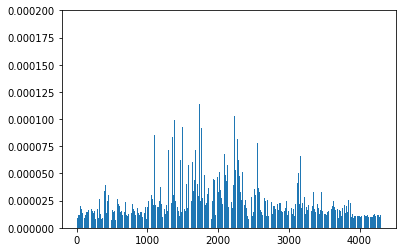

In [19]:
display_range = 0.0002
print(len(all_loss_list))
for i in range(len(all_loss_list)):
    plt.ylim(0, display_range)
    plt.bar(np.arange(len(all_loss_list[i])),all_loss_list[i])
    plt.show()

Training set loss


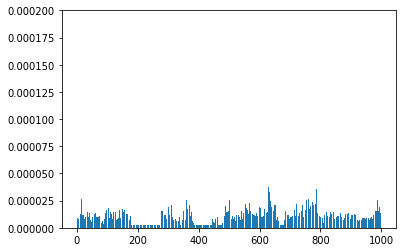

Validation set loss


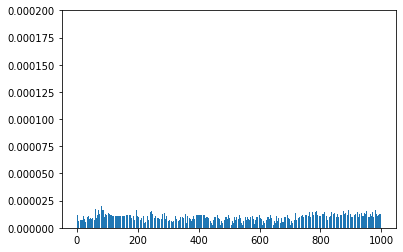

Attack set loss


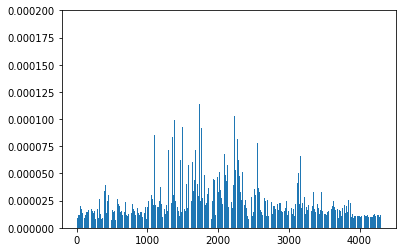

In [17]:
display_range = 0.0002
print('Training set loss')
plt.ylim(0, display_range)
plt.bar(np.arange(len(train_loss)),train_loss)
plt.show()

print('Validation set loss')
plt.ylim(0, display_range)
plt.bar(np.arange(len(val_loss)),val_loss)
plt.show()

print('Attack set loss')
for i in range(len(all_loss_list)):
    plt.ylim(0, display_range)
    plt.bar(np.arange(len(all_loss_list[i])),all_loss_list[i])
    plt.show()